## 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import SGD, Adam, AdamW, RMSprop, Rprop
import torch_optimizer as optim_extra  # Third-party optimizers

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Custom optimizers
from self_optimizers import *
from self_benchmarks import *
import inspect
import math
import pathlib
import os

## 2. Hyperparameters

In [2]:
batch_size = 128
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
manual_seed = 69

history = {}
results = {}

np.random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.cuda.manual_seed(manual_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 3. Train & Evaluate

In [3]:
def train_one_epoch(model, loader, criterion, optimizer):

    def closure():
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        return loss
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        # check optimizer.step has closure as parameter
        sig = inspect.signature(optimizer.step)
        if 'closure' in sig.parameters:
            optimizer.step(closure)
        else:
            optimizer.step()
        running_loss += loss.item() * xb.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            running_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return running_loss / total, correct / total

## 4. Complete Run

In [4]:
def run(SimpleCNN, train_loader, test_loader, num_epochs=20, output_path=None):
    opt_confs = [
        ('SGD', SGD, {'lr': 1e-3, 'momentum': 0.9}),
        ('Adam', Adam, {'lr': 1e-3}),
        ('AdamW', AdamW, {'lr': 1e-3}),
        ('RMSprop', RMSprop, {'lr': 1e-3}),
        ('Yogi', optim_extra.Yogi, {'lr': 1e-3}),
        ('Rprop', Rprop, {'lr': 1e-3}),

        ('RPropMomentum', RPropMomentum, {'lr': 1e-3, 'momentum': 0.9}),
        ('RpropwithPolyak', RpropWithPolyakAveraging, {'lr': 1e-3}),
        ('SGDPolyakMomentum', SGDPolyakMomentum,
         {'lr': 1e-3, 'momentum': 0.9}),

        ('ProxYogi', ProxYogi, {'lr': 1e-3, "prox": lambda u, lr,
                                lam=1e-4: torch.sign(u) * torch.clamp(u.abs() - lr * lam, min=0.0)}),
        ('ProximalHB', ProximalHB, {
         'lr': 1e-2, 'momentum': 0.9, 'lambd': 1e-5}),
        ('AdamQN', AdamQN, {'lr': 1e-3, 'gamma': 0.1, 'eps': 1e-8}),
        ('AMSGradMirror', AMSGradMirror, {'lr': 3e-4}),
    ]
    optimizer_styles = {
        # — Standard optimizers (solid lines) —
        'SGD':    {'linestyle': '-',  'color': 'blue'},
        'Adam':   {'linestyle': '-',  'color': 'orange'},
        'AdamW':  {'linestyle': '-',  'color': 'green'},
        'RMSprop': {'linestyle': '-',  'color': 'red'},
        'Rprop':  {'linestyle': '-',  'color': 'purple'},

        # — Bad‐performing customs (dashed lines) —
        'RpropWithPolyakAveraging': {'linestyle': '--', 'color': 'brown'},
        'SGDPolyakMomentum':        {'linestyle': '--', 'color': 'pink'},
        'ProximalHB':               {'linestyle': '--', 'color': 'gray'},
        'AdamQN':                   {'linestyle': '--', 'color': 'olive'},

        # — Good‐performing customs (dotted lines) —
        'Yogi':          {'linestyle': ':',  'color': 'cyan'},
        'RPropMomentum': {'linestyle': ':',  'color': 'magenta'},
        'ProxYogi':      {'linestyle': ':',  'color': 'teal'},
        'AMSGradMirror': {'linestyle': ':',  'color': 'gold'},
    }
    _default_style = {'linestyle': '-', 'color': 'black'}

    if output_path:
        os.makedirs(output_path, exist_ok=True)
    for name, OptClass, opt_kwargs in tqdm(opt_confs, desc="Optimizers"):
        print(f"\n=== Training with {name} ===")
        model = SimpleCNN().to(device)
        optimizerr = OptClass(model.parameters(), **opt_kwargs)
        history = {'train_acc': [], 'train_loss': [],
                   'val_acc': [], 'val_loss': []}
        # momentum_opt = MomentumSGD(model.parameters(), lr=0.001, momentum=0.9)
        # adam_opt = torch.optim.Adam(model.parameters(), lr=0.001)
        for epoch in trange(1, num_epochs+1, leave=False, desc="Epochs"):
            # optimizer = optimizerr if epoch < 35 else adam_opt
            train_loss, train_acc = train_one_epoch(
                model, train_loader, criterion, optimizerr)
            val_loss, val_acc = evaluate(model, test_loader, criterion)
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            if epoch % 5 == 0 or epoch == 1:
                print(f"Epoch {epoch:2d}/{num_epochs}  "
                      f"Train: loss={train_loss:.4f}, acc={train_acc:.4f}  "
                      f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f}")

        results[name] = history
        if output_path:
            torch.save(model.state_dict(), f"{output_path}/{name}.pth")

    print("\n=== Final Training Accuracies ===")
    for name, hist in results.items():
        print(f"{name:7s}: {hist['train_acc'][-1]*100:.2f}%")

    print("\n=== Final Validation Accuracies ===")
    for name, hist in results.items():
        print(f"{name:7s}: {hist['val_acc'][-1]*100:.2f}%")

    print("\n=== Plotting Results ===")
    to_ignore = []
    # to_ignore = ["RPropMomentum", "RpropwithPolyak", "Rprop"]

    plt.figure(figsize=(10, 5))
    for name, hist in results.items():
        if name in to_ignore:
            continue
        style = optimizer_styles.get(name, _default_style)
        plt.plot(np.arange(1, num_epochs+1), hist['train_loss'],
                label=name, linestyle=style['linestyle'], color=style['color'])
    plt.title('Train Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if output_path:
        plt.savefig(os.path.join(output_path, "train_loss.png"))
    plt.show()

    plt.figure(figsize=(10, 5))
    for name, hist in results.items():
        if name in to_ignore:
            continue
        style = optimizer_styles.get(name, _default_style)
        plt.plot(np.arange(1, num_epochs+1), hist['val_loss'],
                label=name, linestyle=style['linestyle'], color=style['color'])
    plt.title('Val Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Val Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if output_path:
        plt.savefig(os.path.join(output_path, "val_loss.png"))
    plt.show()


## 5. CIFAR10

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = datasets.CIFAR10(root='/home/yash/data',
                            train=True, download=True, transform=transform)
test_ds = datasets.CIFAR10(root='/home/yash/data',
                           train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size,
                          shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds,  batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Conv block 1: 3×32×32 → 32×16×16
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        # Conv block 2: 32×16×16 → 64×8×8
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        # Conv block 3: 64×8×8 → 128×4×4
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        # classifier head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 128×4×4 → 128×1×1
        self.fc      = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Optimizers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Training with SGD ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.8240, acc=0.3550  Val:   loss=1.6168, acc=0.4236
Epoch  5/20  Train: loss=1.2605, acc=0.5584  Val:   loss=1.2847, acc=0.5359
Epoch 10/20  Train: loss=1.0544, acc=0.6321  Val:   loss=1.0967, acc=0.6116
Epoch 15/20  Train: loss=0.9431, acc=0.6688  Val:   loss=0.9971, acc=0.6466
Epoch 20/20  Train: loss=0.8605, acc=0.7018  Val:   loss=0.9374, acc=0.6722

=== Training with Adam ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.3976, acc=0.5028  Val:   loss=1.2506, acc=0.5481
Epoch  5/20  Train: loss=0.8310, acc=0.7134  Val:   loss=0.9065, acc=0.6843
Epoch 10/20  Train: loss=0.6238, acc=0.7875  Val:   loss=0.8642, acc=0.7051
Epoch 15/20  Train: loss=0.4991, acc=0.8335  Val:   loss=0.7905, acc=0.7313
Epoch 20/20  Train: loss=0.3999, acc=0.8706  Val:   loss=0.7256, acc=0.7580

=== Training with AdamW ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.4194, acc=0.4940  Val:   loss=1.2358, acc=0.5583
Epoch  5/20  Train: loss=0.8444, acc=0.7075  Val:   loss=0.9779, acc=0.6452
Epoch 10/20  Train: loss=0.6445, acc=0.7813  Val:   loss=0.7801, acc=0.7285
Epoch 15/20  Train: loss=0.5175, acc=0.8278  Val:   loss=0.7334, acc=0.7490
Epoch 20/20  Train: loss=0.4223, acc=0.8612  Val:   loss=0.7319, acc=0.7479

=== Training with RMSprop ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.4062, acc=0.4946  Val:   loss=1.4238, acc=0.4635
Epoch  5/20  Train: loss=0.8733, acc=0.6974  Val:   loss=1.0589, acc=0.6358
Epoch 10/20  Train: loss=0.6684, acc=0.7700  Val:   loss=0.8628, acc=0.6990
Epoch 15/20  Train: loss=0.5389, acc=0.8183  Val:   loss=0.8816, acc=0.7038
Epoch 20/20  Train: loss=0.4427, acc=0.8538  Val:   loss=1.1076, acc=0.6515

=== Training with Yogi ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.4753, acc=0.4746  Val:   loss=1.3412, acc=0.5090
Epoch  5/20  Train: loss=0.8820, acc=0.6968  Val:   loss=0.9423, acc=0.6650
Epoch 10/20  Train: loss=0.6789, acc=0.7689  Val:   loss=0.8529, acc=0.7037
Epoch 15/20  Train: loss=0.5585, acc=0.8127  Val:   loss=0.7630, acc=0.7344
Epoch 20/20  Train: loss=0.4684, acc=0.8465  Val:   loss=0.7737, acc=0.7347

=== Training with Rprop ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.6717, acc=0.4097  Val:   loss=1.6215, acc=0.4311
Epoch  5/20  Train: loss=1.5988, acc=0.4470  Val:   loss=1.5872, acc=0.4468
Epoch 10/20  Train: loss=1.5615, acc=0.4626  Val:   loss=1.5548, acc=0.4591
Epoch 15/20  Train: loss=1.5319, acc=0.4762  Val:   loss=1.5195, acc=0.4708
Epoch 20/20  Train: loss=1.5020, acc=0.4865  Val:   loss=1.4902, acc=0.4775

=== Training with RPropMomentum ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.6873, acc=0.3977  Val:   loss=1.6281, acc=0.4195
Epoch  5/20  Train: loss=1.6086, acc=0.4352  Val:   loss=1.5971, acc=0.4374
Epoch 10/20  Train: loss=1.5789, acc=0.4484  Val:   loss=1.5692, acc=0.4484
Epoch 15/20  Train: loss=1.5536, acc=0.4596  Val:   loss=1.5444, acc=0.4587
Epoch 20/20  Train: loss=1.5297, acc=0.4695  Val:   loss=1.5236, acc=0.4661

=== Training with RpropwithPolyak ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.6339, acc=0.4235  Val:   loss=1.5798, acc=0.4449
Epoch  5/20  Train: loss=1.5595, acc=0.4602  Val:   loss=1.5460, acc=0.4599
Epoch 10/20  Train: loss=1.5288, acc=0.4733  Val:   loss=1.5163, acc=0.4756
Epoch 15/20  Train: loss=1.5031, acc=0.4830  Val:   loss=1.4956, acc=0.4789
Epoch 20/20  Train: loss=1.4796, acc=0.4925  Val:   loss=1.4745, acc=0.4864

=== Training with SGDPolyakMomentum ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=2.1707, acc=0.2173  Val:   loss=2.0382, acc=0.2805
Epoch  5/20  Train: loss=1.8146, acc=0.3700  Val:   loss=1.7823, acc=0.3805
Epoch 10/20  Train: loss=1.6466, acc=0.4289  Val:   loss=1.6251, acc=0.4332
Epoch 15/20  Train: loss=1.5414, acc=0.4648  Val:   loss=1.5237, acc=0.4702
Epoch 20/20  Train: loss=1.4518, acc=0.4982  Val:   loss=1.4392, acc=0.4992

=== Training with ProxYogi ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

/home/yash/Codes/AOMML/Custom Optimizer and Benchmarking/self_optimizers/prox_yogi.py:51: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1581.)
  v.addcmul_(- (1 - beta2), grad2, diff.sign())


Epoch  1/20  Train: loss=1.3831, acc=0.5019  Val:   loss=1.2412, acc=0.5521
Epoch  5/20  Train: loss=0.8081, acc=0.7228  Val:   loss=0.9443, acc=0.6685
Epoch 10/20  Train: loss=0.6284, acc=0.7858  Val:   loss=0.7835, acc=0.7308
Epoch 15/20  Train: loss=0.5188, acc=0.8267  Val:   loss=0.7356, acc=0.7431
Epoch 20/20  Train: loss=0.4372, acc=0.8581  Val:   loss=0.7309, acc=0.7536

=== Training with ProximalHB ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.4746, acc=0.4661  Val:   loss=1.5070, acc=0.4705
Epoch  5/20  Train: loss=0.8728, acc=0.6949  Val:   loss=0.9257, acc=0.6712
Epoch 10/20  Train: loss=0.6496, acc=0.7765  Val:   loss=0.7731, acc=0.7280
Epoch 15/20  Train: loss=0.5109, acc=0.8258  Val:   loss=0.7983, acc=0.7269
Epoch 20/20  Train: loss=0.4030, acc=0.8650  Val:   loss=0.7396, acc=0.7553

=== Training with AdamQN ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.3463, acc=0.5223  Val:   loss=1.2211, acc=0.5586
Epoch  5/20  Train: loss=0.7821, acc=0.7303  Val:   loss=0.8878, acc=0.6932
Epoch 10/20  Train: loss=0.6035, acc=0.7970  Val:   loss=0.7550, acc=0.7377
Epoch 15/20  Train: loss=0.4825, acc=0.8394  Val:   loss=0.6897, acc=0.7560
Epoch 20/20  Train: loss=0.3935, acc=0.8707  Val:   loss=0.6641, acc=0.7697

=== Training with AMSGradMirror ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.3819, acc=0.5091  Val:   loss=1.2040, acc=0.5651
Epoch  5/20  Train: loss=0.9129, acc=0.6862  Val:   loss=0.9575, acc=0.6606
Epoch 10/20  Train: loss=0.7628, acc=0.7392  Val:   loss=0.9032, acc=0.6823
Epoch 15/20  Train: loss=0.6739, acc=0.7708  Val:   loss=0.8119, acc=0.7155
Epoch 20/20  Train: loss=0.6060, acc=0.7979  Val:   loss=0.7703, acc=0.7358

=== Final Training Accuracies ===
SGD    : 70.18%
Adam   : 87.06%
AdamW  : 86.12%
RMSprop: 85.38%
Yogi   : 84.65%
Rprop  : 48.65%
RPropMomentum: 46.95%
RpropwithPolyak: 49.25%
SGDPolyakMomentum: 49.82%
ProxYogi: 85.81%
ProximalHB: 86.50%
AdamQN : 87.07%
AMSGradMirror: 79.79%

=== Final Validation Accuracies ===
SGD    : 67.22%
Adam   : 75.80%
AdamW  : 74.79%
RMSprop: 65.15%
Yogi   : 73.47%
Rprop  : 47.75%
RPropMomentum: 46.61%
RpropwithPolyak: 48.64%
SGDPolyakMomentum: 49.92%
ProxYogi: 75.36%
ProximalHB: 75.53%
AdamQN : 76.97%
AMSGradMirror: 73.58%

=== Plotting Results ===


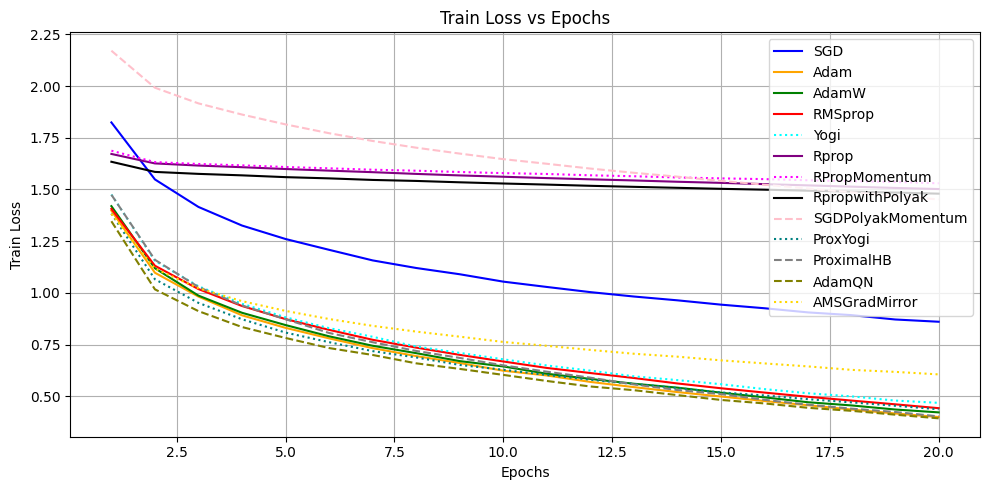

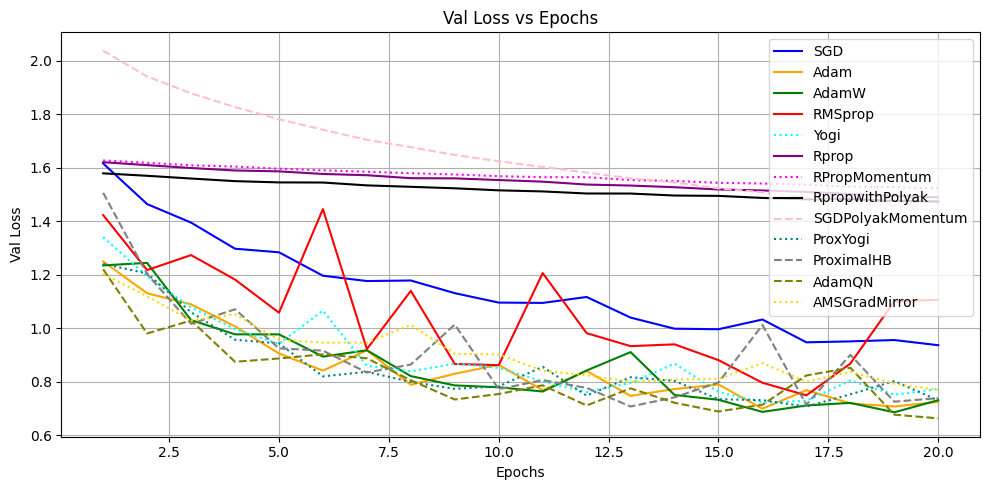

In [7]:
run(SimpleCNN, train_loader, test_loader, num_epochs, output_path="results/cifar10")

## 6. MNIST

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = datasets.MNIST(root='/home/yash/data',
                          train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root='/home/yash/data',
                         train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size,
                          shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds,  batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Conv block 1: 1×28×28 → 32×14×14
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        # Conv block 2: 32×14×14 → 64×7×7
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        # classifier head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 64×7×7 → 64×1×1
        self.fc      = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Optimizers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Training with SGD ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=2.0959, acc=0.3268  Val:   loss=1.9076, acc=0.4310
Epoch  5/20  Train: loss=1.2713, acc=0.6755  Val:   loss=1.1853, acc=0.7112
Epoch 10/20  Train: loss=0.7945, acc=0.8327  Val:   loss=0.7324, acc=0.8535
Epoch 15/20  Train: loss=0.5080, acc=0.8990  Val:   loss=0.4730, acc=0.9109
Epoch 20/20  Train: loss=0.3588, acc=0.9270  Val:   loss=0.3505, acc=0.9214

=== Training with Adam ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.3562, acc=0.6544  Val:   loss=0.8469, acc=0.8222
Epoch  5/20  Train: loss=0.2352, acc=0.9474  Val:   loss=0.2444, acc=0.9411
Epoch 10/20  Train: loss=0.1310, acc=0.9684  Val:   loss=0.1414, acc=0.9633
Epoch 15/20  Train: loss=0.0968, acc=0.9757  Val:   loss=0.1447, acc=0.9583
Epoch 20/20  Train: loss=0.0759, acc=0.9810  Val:   loss=0.0955, acc=0.9738

=== Training with AdamW ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.3603, acc=0.6510  Val:   loss=0.8662, acc=0.8199
Epoch  5/20  Train: loss=0.2456, acc=0.9435  Val:   loss=0.2776, acc=0.9252
Epoch 10/20  Train: loss=0.1425, acc=0.9644  Val:   loss=0.1558, acc=0.9592
Epoch 15/20  Train: loss=0.1042, acc=0.9741  Val:   loss=0.1386, acc=0.9625
Epoch 20/20  Train: loss=0.0846, acc=0.9786  Val:   loss=0.1240, acc=0.9635

=== Training with RMSprop ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.1398, acc=0.7268  Val:   loss=0.8118, acc=0.7987
Epoch  5/20  Train: loss=0.2374, acc=0.9460  Val:   loss=0.2502, acc=0.9366
Epoch 10/20  Train: loss=0.1327, acc=0.9676  Val:   loss=0.3946, acc=0.8622
Epoch 15/20  Train: loss=0.0955, acc=0.9765  Val:   loss=0.1214, acc=0.9648
Epoch 20/20  Train: loss=0.0748, acc=0.9810  Val:   loss=0.2682, acc=0.9072

=== Training with Yogi ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.5226, acc=0.5748  Val:   loss=1.0251, acc=0.7592
Epoch  5/20  Train: loss=0.2848, acc=0.9373  Val:   loss=0.2992, acc=0.9268
Epoch 10/20  Train: loss=0.1630, acc=0.9608  Val:   loss=0.1710, acc=0.9567
Epoch 15/20  Train: loss=0.1212, acc=0.9699  Val:   loss=0.1291, acc=0.9673
Epoch 20/20  Train: loss=0.0988, acc=0.9754  Val:   loss=0.1081, acc=0.9712

=== Training with Rprop ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.5054, acc=0.5505  Val:   loss=1.3661, acc=0.6250
Epoch  5/20  Train: loss=1.3286, acc=0.6318  Val:   loss=1.2886, acc=0.6370
Epoch 10/20  Train: loss=1.2849, acc=0.6474  Val:   loss=1.2462, acc=0.6585
Epoch 15/20  Train: loss=1.2413, acc=0.6649  Val:   loss=1.2087, acc=0.6834
Epoch 20/20  Train: loss=1.2191, acc=0.6747  Val:   loss=1.1870, acc=0.6947

=== Training with RPropMomentum ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.4549, acc=0.5636  Val:   loss=1.3129, acc=0.6209
Epoch  5/20  Train: loss=1.2384, acc=0.6476  Val:   loss=1.2140, acc=0.6624
Epoch 10/20  Train: loss=1.2113, acc=0.6663  Val:   loss=1.1833, acc=0.6816
Epoch 15/20  Train: loss=1.1826, acc=0.6817  Val:   loss=1.1556, acc=0.6952
Epoch 20/20  Train: loss=1.1607, acc=0.6937  Val:   loss=1.1345, acc=0.7095

=== Training with RpropwithPolyak ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.4505, acc=0.5843  Val:   loss=1.3039, acc=0.6552
Epoch  5/20  Train: loss=1.2568, acc=0.6686  Val:   loss=1.2241, acc=0.6832
Epoch 10/20  Train: loss=1.2173, acc=0.6818  Val:   loss=1.1887, acc=0.6985
Epoch 15/20  Train: loss=1.1943, acc=0.6959  Val:   loss=1.1631, acc=0.7082
Epoch 20/20  Train: loss=1.1696, acc=0.7027  Val:   loss=1.1412, acc=0.7198

=== Training with SGDPolyakMomentum ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=2.2897, acc=0.1616  Val:   loss=2.2324, acc=0.2268
Epoch  5/20  Train: loss=2.0825, acc=0.3494  Val:   loss=2.0630, acc=0.3481
Epoch 10/20  Train: loss=1.9220, acc=0.4044  Val:   loss=1.9014, acc=0.4121
Epoch 15/20  Train: loss=1.7814, acc=0.4569  Val:   loss=1.7612, acc=0.4688
Epoch 20/20  Train: loss=1.6643, acc=0.5109  Val:   loss=1.6438, acc=0.5201

=== Training with ProxYogi ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.0736, acc=0.7127  Val:   loss=0.5962, acc=0.8659
Epoch  5/20  Train: loss=0.2124, acc=0.9518  Val:   loss=0.2227, acc=0.9440
Epoch 10/20  Train: loss=0.1352, acc=0.9676  Val:   loss=0.1487, acc=0.9617
Epoch 15/20  Train: loss=0.1044, acc=0.9748  Val:   loss=0.1114, acc=0.9712
Epoch 20/20  Train: loss=0.0868, acc=0.9782  Val:   loss=0.1362, acc=0.9618

=== Training with ProximalHB ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.3861, acc=0.5893  Val:   loss=0.8779, acc=0.7690
Epoch  5/20  Train: loss=0.2043, acc=0.9510  Val:   loss=0.3690, acc=0.8781
Epoch 10/20  Train: loss=0.1182, acc=0.9700  Val:   loss=0.2612, acc=0.9222
Epoch 15/20  Train: loss=0.0873, acc=0.9775  Val:   loss=0.1886, acc=0.9444
Epoch 20/20  Train: loss=0.0720, acc=0.9814  Val:   loss=0.1380, acc=0.9590

=== Training with AdamQN ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.0283, acc=0.7469  Val:   loss=0.6444, acc=0.8213
Epoch  5/20  Train: loss=0.1984, acc=0.9536  Val:   loss=0.2145, acc=0.9452
Epoch 10/20  Train: loss=0.1192, acc=0.9707  Val:   loss=0.1468, acc=0.9601
Epoch 15/20  Train: loss=0.0871, acc=0.9779  Val:   loss=0.1188, acc=0.9657
Epoch 20/20  Train: loss=0.0688, acc=0.9825  Val:   loss=0.1000, acc=0.9709

=== Training with AMSGradMirror ===


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1/20  Train: loss=1.3155, acc=0.6882  Val:   loss=0.9457, acc=0.8151
Epoch  5/20  Train: loss=0.4254, acc=0.9152  Val:   loss=0.3873, acc=0.9236
Epoch 10/20  Train: loss=0.2620, acc=0.9438  Val:   loss=0.2445, acc=0.9453
Epoch 15/20  Train: loss=0.1990, acc=0.9557  Val:   loss=0.2080, acc=0.9490
Epoch 20/20  Train: loss=0.1632, acc=0.9627  Val:   loss=0.1649, acc=0.9604

=== Final Training Accuracies ===
SGD    : 92.70%
Adam   : 98.10%
AdamW  : 97.86%
RMSprop: 98.10%
Yogi   : 97.54%
Rprop  : 67.47%
RPropMomentum: 69.37%
RpropwithPolyak: 70.27%
SGDPolyakMomentum: 51.09%
ProxYogi: 97.82%
ProximalHB: 98.14%
AdamQN : 98.25%
AMSGradMirror: 96.27%

=== Final Validation Accuracies ===
SGD    : 92.14%
Adam   : 97.38%
AdamW  : 96.35%
RMSprop: 90.72%
Yogi   : 97.12%
Rprop  : 69.47%
RPropMomentum: 70.95%
RpropwithPolyak: 71.98%
SGDPolyakMomentum: 52.01%
ProxYogi: 96.18%
ProximalHB: 95.90%
AdamQN : 97.09%
AMSGradMirror: 96.04%

=== Plotting Results ===


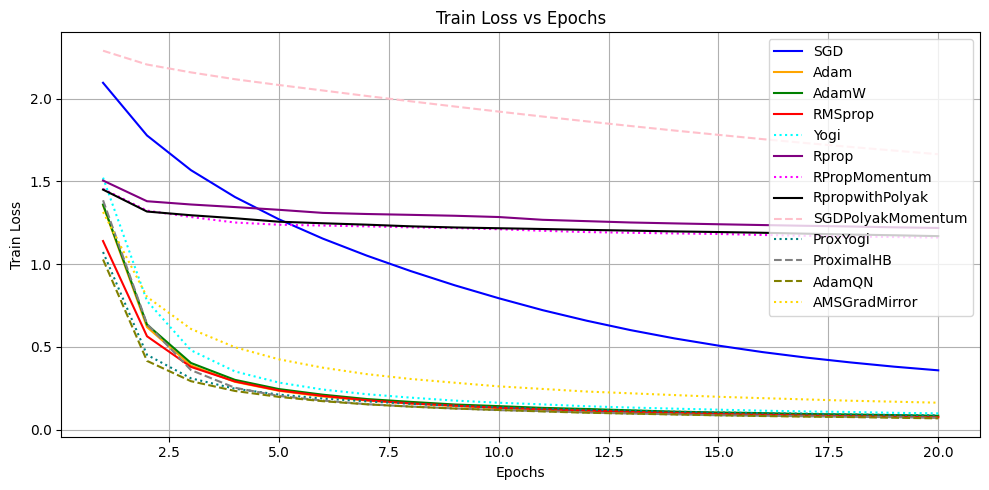

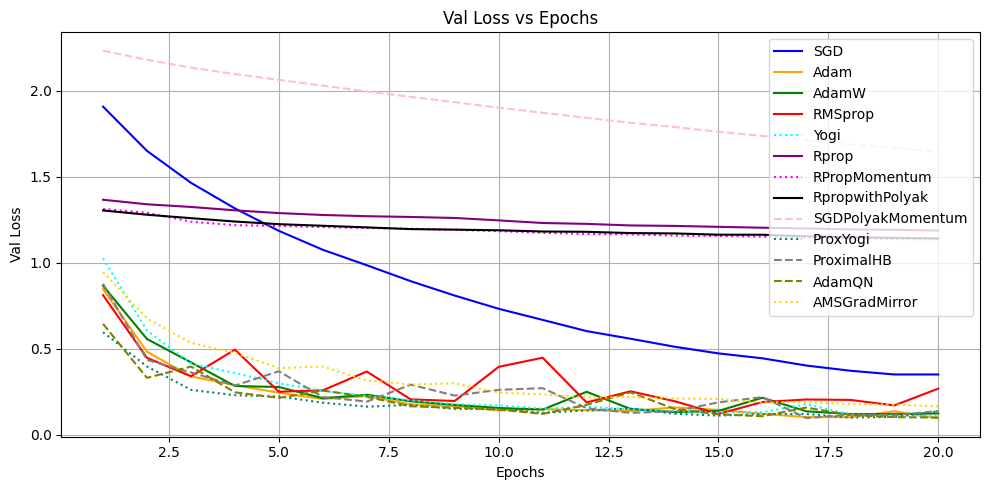

In [10]:
run(SimpleCNN, train_loader, test_loader, num_epochs, output_path="results/mnist")

## 7. Other Benchmarks

In [11]:
opt_confs = [
    ('SGD', SGD, {'lr': 1e-3, 'momentum': 0.9}),
    ('Adam', Adam, {'lr': 1e-3}),
    ('AdamW', AdamW, {'lr': 1e-3}),
    ('RMSprop', RMSprop, {'lr': 1e-3}),
    ('Yogi', optim_extra.Yogi, {'lr': 1e-3}),
    ('Rprop', Rprop, {'lr': 1e-3}),

    ('RPropMomentum', RPropMomentum, {'lr': 1e-3, 'momentum': 0.9}),
    ('RpropwithPolyak', RpropWithPolyakAveraging, {'lr': 1e-3}),
    ('SGDPolyakMomentum', SGDPolyakMomentum,
        {'lr': 1e-3, 'momentum': 0.9}),

    ('ProxYogi', ProxYogi, {'lr': 1e-3, "prox": lambda u, lr,
                            lam=1e-4: torch.sign(u) * torch.clamp(u.abs() - lr * lam, min=0.0)}),
    ('ProximalHB', ProximalHB, {
        'lr': 1e-2, 'momentum': 0.9, 'lambd': 1e-5}),
    ('AdamQN', AdamQN, {'lr': 1e-3, 'gamma': 0.1, 'eps': 1e-8}),
    ('AMSGradMirror', AMSGradMirror, {'lr': 3e-4}),
]


optimizer_styles = {
    # — Standard optimizers (solid lines) —
    'SGD':    {'linestyle': '-',  'color': 'blue'},
    'Adam':   {'linestyle': '-',  'color': 'orange'},
    'AdamW':  {'linestyle': '-',  'color': 'green'},
    'RMSprop': {'linestyle': '-',  'color': 'red'},
    'Rprop':  {'linestyle': '-',  'color': 'purple'},

    # — Bad‐performing customs (dashed lines) —
    'RpropWithPolyakAveraging': {'linestyle': '--', 'color': 'brown'},
    'SGDPolyakMomentum':        {'linestyle': '--', 'color': 'pink'},
    'ProximalHB':               {'linestyle': '--', 'color': 'gray'},
    'AdamQN':                   {'linestyle': '--', 'color': 'olive'},

    # — Good‐performing customs (dotted lines) —
    'Yogi':          {'linestyle': ':',  'color': 'cyan'},
    'RPropMomentum': {'linestyle': ':',  'color': 'magenta'},
    'ProxYogi':      {'linestyle': ':',  'color': 'teal'},
    'AMSGradMirror': {'linestyle': ':',  'color': 'gold'},
}
_default_style = {'linestyle': '-', 'color': 'black'}

# --- Define Functions Dictionary (`funcs`) ---
funcs = {
    'Ackley Function': {
        'func': ackley,
        'dim': 2,
        'domain': [(-5.0, 5.0), (-5.0, 5.0)],
    },
    'Bukin Function N. 6': {
        'func': bukin_n6,
        'dim': 2,
        'domain': [(-15.0, -5.0), (-3.0, 3.0)],
    },
    'Cross-in-Tray Function': {
        'func': cross_in_tray,
        'dim': 2,
        'domain': [(-10.0, 10.0), (-10.0, 10.0)],
    },
    'Drop-Wave Function': {
        'func': drop_wave,
        'dim': 2,
        'domain': [(-5.12, 5.12), (-5.12, 5.12)],
    },
    'Eggholder Function': {
        'func': eggholder,
        'dim': 2,
        'domain': [(-512.0, 512.0), (-512.0, 512.0)],
    },
    'Gramacy & Lee (2012) Function': {
        'func': gramacy_lee,
        'dim': 1,
        'domain': [(0.5, 2.5)],
    },
    'Griewank Function': {
        'func': griewank,
        'dim': 2,
        'domain': [(-5.0, 5.0), (-5.0, 5.0)],
    },
    'Holder Table Function': {
        'func': holder_table,
        'dim': 2,
        'domain': [(-10.0, 10.0), (-10.0, 10.0)],
    },
    'Langermann Function': {
        'func': langermann,
        'dim': 2,
        'domain': [(0.0, 10.0), (0.0, 10.0)],
    },
    'Levy Function': {
        'func': levy,
        'dim': 2,
        'domain': [(-10.0, 10.0), (-10.0, 10.0)],
    },
    'Levy Function N. 13': {
        'func': levy_n13,
        'dim': 2,
        'domain': [(-10.0, 10.0), (-10.0, 10.0)],
    },
    'Rastrigin Function': {
        'func': rastrigin,
        'dim': 2,
        'domain': [(-5.12, 5.12), (-5.12, 5.12)],
    },
    'Schaffer Function N. 2': {
        'func': schaffer_n2,
        'dim': 2,
        'domain': [(-100.0, 100.0), (-100.0, 100.0)],
    },
    'Schaffer Function N. 4': {
        'func': schaffer_n4,
        'dim': 2,
        'domain': [(-100.0, 100.0), (-100.0, 100.0)],
    },
    'Schwefel Function': {
        'func': schwefel,
        'dim': 2,
        'domain': [(-500.0, 500.0), (-500.0, 500.0)],
    },
    'Shubert Function': {
        'func': shubert,
        'dim': 2,
        'domain': [(-10.0, 10.0), (-10.0, 10.0)],
    },
    'Bohachevsky Function': {
        'func': bohachevsky,
        'dim': 2,
        'domain': [(-10.0, 10.0), (-10.0, 10.0)],
    },
    'Perm Function 0 (d=2, β=0)': {
        'func': perm_0,
        'dim': 2,
        'domain': [(-2.0, 2.0), (-2.0, 2.0)],
    },
    'Rotated Hyper-Ellipsoid Function': {
        'func': rotated_hyper_ellipsoid,
        'dim': 2,
        'domain': [(-5.0, 5.0), (-5.0, 5.0)],
    },
    'Sphere Function': {
        'func': sphere,
        'dim': 2,
        'domain': [(-5.0, 5.0), (-5.0, 5.0)],
    },
    'Sum of Different Powers Function': {
        'func': sum_different_powers,
        'dim': 2,
        'domain': [(-1.0, 1.0), (-1.0, 1.0)],
    },
    'Sum Squares Function': {
        'func': sum_squares,
        'dim': 2,
        'domain': [(-5.0, 5.0), (-5.0, 5.0)],
    },
    'Trid Function': {
        'func': trid,
        'dim': 2,
        'domain': [(-4.0, 4.0), (-4.0, 4.0)],
    },
    'Booth Function': {
        'func': booth,
        'dim': 2,
        'domain': [(-10.0, 10.0), (-10.0, 10.0)],
    },
    'Matyas Function': {
        'func': matyas,
        'dim': 2,
        'domain': [(-10.0, 10.0), (-10.0, 10.0)],
    },
    'McCormick Function': {
        'func': mccormick,
        'dim': 2,
        'domain': [(-1.5, 4.0), (-3.0, 4.0)],
    },
    'Power Sum Function': {
        'func': power_sum,
        'dim': 2,
        'domain': [(-5.0, 5.0), (-5.0, 5.0)],
    },
    'Zakharov Function': {
        'func': zakharov,
        'dim': 2,
        'domain': [(-5.0, 10.0), (-5.0, 10.0)],
    },
    'Three-Hump Camel Function': {
        'func': three_hump_camel,
        'dim': 2,
        'domain': [(-5.0, 5.0), (-5.0, 5.0)],
    },
    'Six-Hump Camel Function': {
        'func': six_hump_camel,
        'dim': 2,
        'domain': [(-3.0, 3.0), (-2.0, 2.0)],
    },
    'Dixon-Price Function': {
        'func': dixon_price,
        'dim': 2,
        'domain': [(-10.0, 10.0), (-10.0, 10.0)],
    },
    'Rosenbrock Function': {
        'func': rosenbrock,
        'dim': 2,
        'domain': [(-5.0, 10.0), (-5.0, 10.0)],
    },
    'De Jong Function N. 5': {
        'func': de_jong_n5,
        'dim': 2,
        'domain': [(-32.768, 32.768), (-32.768, 32.768)],
    },
    'Easom Function': {
        'func': easom,
        'dim': 2,
        'domain': [(-100.0, 100.0), (-100.0, 100.0)],
    },
    'Michalewicz Function': {
        'func': michalewicz,
        'dim': 2,
        'domain': [(0.0, math.pi), (0.0, math.pi)],
    },
    'Beale Function': {
        'func': beale,
        'dim': 2,
        'domain': [(-4.5, 4.5), (-4.5, 4.5)],
    },
    'Branin Function': {
        'func': branin,
        'dim': 2,
        'domain': [(-5, 10), (0, 15)],
    },
    'Colville Function': {
        'func': colville,
        'dim': 4,
        'domain': [(-10, 10)] * 4,
    },
    'Forrester Function': {
        'func': forrester,
        'dim': 1,
        'domain': [(0, 1)],
    },
    'Goldstein-Price Function': {
        'func': goldstein_price,
        'dim': 2,
        'domain': [(-2, 2)] * 2,
    },
    'Hartmann 3-D Function': {
        'func': hartmann3d,
        'dim': 3,
        'domain': [(0, 1)] * 3,
    },
    'Hartmann 4-D Function': {
        'func': hartmann4d,
        'dim': 4,
        'domain': [(0, 1)] * 4,
    },
    'Hartmann 6-D Function': {
        'func': hartmann6d,
        'dim': 6,
        'domain': [(0, 1)] * 6,
    },
    'Perm Function (d=4, β=10)': {
        'func': lambda x: perm(x, d=4, beta=10),
        'dim': 4,
        'domain': [(-4, 4)] * 4,
    },
    'Powell Function': {
        'func': powell,
        'dim': 4,
        'domain': [(-4, 5)] * 4,
    },
    'Shekel Function (m=10)': {
        'func': lambda x: shekel(x, m=10),
        'dim': 4,
        'domain': [(0, 10)] * 4,
    },
    'Styblinski-Tang Function': {
        'func': styblinski_tang,
        'dim': 2,
        'domain': [(-5, 5)] * 2,
    },
}

In [12]:
def init_x(domain, dtype, device):
    return torch.tensor([(lo + hi) / 2.0 for lo, hi in domain],
                        dtype=dtype, device=device, requires_grad=True)

def safe_scalar(t):
    if isinstance(t, torch.Tensor):
        t = t.item()
    return t if (isinstance(t, (int, float)) and math.isfinite(t)) else float('nan')

def benchmark_and_plot(funcs, opt_confs, n_steps=200,
                       dtype=torch.float32, device=torch.device('cpu'),
                       results_root='results/functions'):

    results_root = pathlib.Path(results_root)
    results_root.mkdir(parents=True, exist_ok=True)

    summary_records = []

    for fn_name, cfg in tqdm(funcs.items(), desc='Functions'):
        fn, domain = cfg['func'], cfg['domain']
        curves = {}
        per_fn_rows = []

        # ---------------- run every optimiser -----------------
        for opt_name, OptCls, opt_kwargs in tqdm(opt_confs,
                                                 desc='Optimisers', leave=False):
            x = init_x(domain, dtype, device)
            try:
                opt = OptCls([x], **opt_kwargs)
            except Exception as e:
                print(f"[{fn_name}/{opt_name}] instantiation failed → {e}")
                losses = [float('nan')] * n_steps
                curves[opt_name] = losses
                per_fn_rows.append(
                    dict(optimizer=opt_name, min_abs_loss=np.nan,
                         last_abs_loss=np.nan))
                continue

            losses, failed = [], False
            for step in range(n_steps):
                cur = abs(safe_scalar(fn(x)))
                losses.append(cur)

                if not math.isfinite(cur):
                    failed = True
                    break

                closure_needed = isinstance(opt, torch.optim.LBFGS) or (
                    'closure' in inspect.signature(opt.step).parameters)

                if closure_needed:
                    def closure():
                        opt.zero_grad()
                        loss = fn(x)
                        loss.backward()
                        return loss
                    try:
                        opt.step(closure)
                    except Exception:
                        failed = True
                        break
                else:
                    opt.zero_grad()
                    loss = fn(x)
                    if not torch.isfinite(loss):
                        failed = True
                        break
                    loss.backward()
                    if x.grad is None or not torch.isfinite(x.grad).all():
                        failed = True
                        break
                    opt.step()

                if not torch.isfinite(x).all():
                    failed = True
                    break

            if len(losses) < n_steps:
                losses.extend([float('nan')] * (n_steps - len(losses)))
            elif failed and math.isfinite(losses[-1]):
                losses[-1] = float('nan')

            curves[opt_name] = losses
            per_fn_rows.append(
                dict(optimizer=opt_name,
                     min_abs_loss=np.nanmin(losses),
                     last_abs_loss=losses[-1]))

        # ---------------- ranking for this function ------------
        df_fn = pd.DataFrame(per_fn_rows)
        df_fn['rank'] = (df_fn['min_abs_loss']
                         .rank(method='min')
                         .where(df_fn['min_abs_loss'].notna()))
        df_fn.sort_values('rank', inplace=True)
        df_fn.reset_index(drop=True, inplace=True)

        # console print
        print(f"\n=== {fn_name} ===")
        print(df_fn[['rank', 'optimizer', 'min_abs_loss', 'last_abs_loss']]
              .to_string(index=False, float_format='%.3e'))

        # save ranks into global summary
        for row in df_fn.to_dict(orient='records'):
            summary_records.append({'function': fn_name, **row})

        # ---------------- plot, skipping NaNs ------------------
        fig, ax = plt.subplots()
        xs = np.arange(n_steps)
        for opt_name, losses in curves.items():
            style = optimizer_styles.get(opt_name, _default_style)
            y = np.asarray(losses, dtype=float)
            ax.plot(xs[~np.isnan(y)], y[~np.isnan(y)], label=opt_name, **style)

        # ax.set_yscale('log')
        ax.set_xlabel('epoch'); ax.set_ylabel('|loss|')
        ax.set_title(fn_name); ax.legend(ncol=2, fontsize='small')
        fig.savefig(results_root / f"{fn_name}.png", dpi=300)
        plt.close(fig)

    # --------------- global CSV with ranks --------------------
    df_all = pd.DataFrame(summary_records)
    csv_path = results_root / "_summary.csv"
    df_all.to_csv(csv_path, index=False)
    print(f"\nGlobal summary (with ranks) → {csv_path.resolve()}")
    
benchmark_and_plot(funcs, opt_confs, n_steps=50,
                   dtype=torch.float32, device=torch.device('cpu'),
                   results_root='results/functions')

Functions:   0%|          | 0/47 [00:00<?, ?it/s]

Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Ackley Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00            NaN
1.000e+00              Adam     0.000e+00            NaN
1.000e+00             AdamW     0.000e+00            NaN
1.000e+00           RMSprop     0.000e+00            NaN
1.000e+00              Yogi     0.000e+00            NaN
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00            NaN
1.000e+00          ProxYogi     0.000e+00            NaN
1.000e+00        ProximalHB     0.000e+00            NaN
1.000e+00            AdamQN     0.000e+00            NaN
1.000e+00     AMSGradMirror     0.000e+00            NaN


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Bukin Function N. 6 ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00     RPropMomentum     4.499e-01      4.526e-01
2.000e+00             Rprop     1.319e+00      1.319e+00
2.000e+00   RpropwithPolyak     1.319e+00      1.319e+00
4.000e+00 SGDPolyakMomentum     3.780e+00      3.150e+01
5.000e+00               SGD     4.629e+00      2.576e+02
6.000e+00        ProximalHB     2.514e+01      2.075e+02
7.000e+00          ProxYogi     8.170e+01      8.170e+01
8.000e+00           RMSprop     9.164e+01      9.164e+01
9.000e+00     AMSGradMirror     9.493e+01      9.493e+01
1.000e+01            AdamQN     9.626e+01      9.626e+01
1.100e+01             AdamW     9.696e+01      9.696e+01
1.200e+01              Adam     9.701e+01      9.701e+01
1.300e+01              Yogi     9.702e+01      9.702e+01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_6405/1148785168.py:86: RuntimeWarning: All-NaN axis encountered
  min_abs_loss=np.nanmin(losses),



=== Cross-in-Tray Function ===
 rank         optimizer  min_abs_loss  last_abs_loss
  NaN               SGD           NaN            NaN
  NaN              Adam           NaN            NaN
  NaN             AdamW           NaN            NaN
  NaN           RMSprop           NaN            NaN
  NaN              Yogi           NaN            NaN
  NaN             Rprop           NaN            NaN
  NaN     RPropMomentum           NaN            NaN
  NaN   RpropwithPolyak           NaN            NaN
  NaN SGDPolyakMomentum           NaN            NaN
  NaN          ProxYogi           NaN            NaN
  NaN        ProximalHB           NaN            NaN
  NaN            AdamQN           NaN            NaN
  NaN     AMSGradMirror           NaN            NaN


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Drop-Wave Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     1.000e+00            NaN
1.000e+00              Adam     1.000e+00            NaN
1.000e+00             AdamW     1.000e+00            NaN
1.000e+00           RMSprop     1.000e+00            NaN
1.000e+00              Yogi     1.000e+00            NaN
1.000e+00             Rprop     1.000e+00      1.000e+00
1.000e+00     RPropMomentum     1.000e+00      1.000e+00
1.000e+00   RpropwithPolyak     1.000e+00      1.000e+00
1.000e+00 SGDPolyakMomentum     1.000e+00            NaN
1.000e+00          ProxYogi     1.000e+00            NaN
1.000e+00        ProximalHB     1.000e+00            NaN
1.000e+00            AdamQN     1.000e+00            NaN
1.000e+00     AMSGradMirror     1.000e+00            NaN


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Eggholder Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     2.546e+01      3.156e+01
1.000e+00              Adam     2.546e+01      2.572e+01
1.000e+00             AdamW     2.546e+01      2.572e+01
1.000e+00           RMSprop     2.546e+01      2.617e+01
1.000e+00              Yogi     2.546e+01      2.572e+01
1.000e+00             Rprop     2.546e+01      6.644e+01
1.000e+00     RPropMomentum     2.546e+01      6.682e+01
1.000e+00   RpropwithPolyak     2.546e+01      6.644e+01
1.000e+00 SGDPolyakMomentum     2.546e+01      2.609e+01
1.000e+00          ProxYogi     2.546e+01      2.692e+01
1.000e+00        ProximalHB     2.546e+01      6.320e+01
1.000e+00            AdamQN     2.546e+01      2.579e+01
1.000e+00     AMSGradMirror     2.546e+01      2.590e+01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Gramacy & Lee (2012) Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00        ProximalHB     5.708e-04      2.336e-01
2.000e+00            AdamQN     2.974e-03      2.310e-01
3.000e+00              Adam     3.370e-03      2.277e-01
4.000e+00              Yogi     3.412e-03      2.274e-01
5.000e+00             AdamW     4.243e-03      2.268e-01
6.000e+00     AMSGradMirror     7.037e-03      2.302e-01
7.000e+00 SGDPolyakMomentum     7.410e-03      2.322e-01
8.000e+00             Rprop     9.478e-03      2.323e-01
8.000e+00     RPropMomentum     9.478e-03      2.323e-01
8.000e+00   RpropwithPolyak     9.478e-03      2.323e-01
1.100e+01          ProxYogi     1.004e-02      2.309e-01
1.200e+01               SGD     3.441e-02      2.304e-01
1.300e+01           RMSprop     3.467e-02      2.323e-01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Griewank Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      0.000e+00
1.000e+00              Adam     0.000e+00      0.000e+00
1.000e+00             AdamW     0.000e+00      0.000e+00
1.000e+00           RMSprop     0.000e+00      0.000e+00
1.000e+00              Yogi     0.000e+00      0.000e+00
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00      0.000e+00
1.000e+00          ProxYogi     0.000e+00      0.000e+00
1.000e+00        ProximalHB     0.000e+00      0.000e+00
1.000e+00            AdamQN     0.000e+00      0.000e+00
1.000e+00     AMSGradMirror     0.000e+00      0.000e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Holder Table Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00            NaN
1.000e+00              Adam     0.000e+00            NaN
1.000e+00             AdamW     0.000e+00            NaN
1.000e+00           RMSprop     0.000e+00            NaN
1.000e+00              Yogi     0.000e+00            NaN
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00            NaN
1.000e+00          ProxYogi     0.000e+00            NaN
1.000e+00        ProximalHB     0.000e+00            NaN
1.000e+00            AdamQN     0.000e+00            NaN
1.000e+00     AMSGradMirror     0.000e+00            NaN


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Langermann Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00     RPropMomentum     1.072e-03      3.281e-01
2.000e+00             Rprop     1.073e-03      3.281e-01
2.000e+00   RpropwithPolyak     1.073e-03      3.281e-01
4.000e+00          ProxYogi     2.002e-03      3.225e-01
5.000e+00     AMSGradMirror     2.290e-03      2.454e-02
6.000e+00           RMSprop     3.250e-03      2.336e-01
7.000e+00        ProximalHB     1.538e-02      3.275e-01
8.000e+00               SGD     1.775e-02      3.145e-01
9.000e+00            AdamQN     7.365e-02      7.365e-02
1.000e+01              Adam     8.157e-02      8.157e-02
1.100e+01              Yogi     8.229e-02      8.229e-02
1.200e+01             AdamW     8.727e-02      8.727e-02
1.300e+01 SGDPolyakMomentum     1.434e-01      1.434e-01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Levy Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00     RPropMomentum     9.694e-09      1.247e-08
2.000e+00             Rprop     1.920e-07      1.031e-06
2.000e+00   RpropwithPolyak     1.920e-07      1.031e-06
4.000e+00        ProximalHB     8.239e-03      9.137e-03
5.000e+00          ProxYogi     4.484e-01      4.484e-01
6.000e+00               SGD     4.572e-01      4.572e-01
7.000e+00           RMSprop     5.829e-01      5.829e-01
8.000e+00     AMSGradMirror     6.329e-01      6.329e-01
9.000e+00            AdamQN     6.538e-01      6.538e-01
1.000e+01              Adam     6.662e-01      6.662e-01
1.100e+01             AdamW     6.663e-01      6.663e-01
1.200e+01              Yogi     6.666e-01      6.666e-01
1.300e+01 SGDPolyakMomentum     6.901e-01      6.901e-01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Levy Function N. 13 ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00           RMSprop     1.981e+00      1.981e+00
1.000e+00             Rprop     1.981e+00      1.981e+00
1.000e+00     RPropMomentum     1.981e+00      1.981e+00
1.000e+00   RpropwithPolyak     1.981e+00      1.981e+00
5.000e+00            AdamQN     1.981e+00      1.981e+00
6.000e+00               SGD     1.981e+00      1.981e+00
7.000e+00          ProxYogi     1.981e+00      1.981e+00
8.000e+00        ProximalHB     1.981e+00      1.981e+00
9.000e+00     AMSGradMirror     1.981e+00      1.981e+00
1.000e+01              Adam     1.981e+00      1.981e+00
1.100e+01             AdamW     1.981e+00      1.981e+00
1.200e+01              Yogi     1.981e+00      1.981e+00
1.300e+01 SGDPolyakMomentum     1.981e+00      1.981e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Rastrigin Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      0.000e+00
1.000e+00              Adam     0.000e+00      0.000e+00
1.000e+00             AdamW     0.000e+00      0.000e+00
1.000e+00           RMSprop     0.000e+00      0.000e+00
1.000e+00              Yogi     0.000e+00      0.000e+00
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00      0.000e+00
1.000e+00          ProxYogi     0.000e+00      0.000e+00
1.000e+00        ProximalHB     0.000e+00      0.000e+00
1.000e+00            AdamQN     0.000e+00      0.000e+00
1.000e+00     AMSGradMirror     0.000e+00      0.000e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Schaffer Function N. 2 ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      0.000e+00
1.000e+00              Adam     0.000e+00      0.000e+00
1.000e+00             AdamW     0.000e+00      0.000e+00
1.000e+00           RMSprop     0.000e+00      0.000e+00
1.000e+00              Yogi     0.000e+00      0.000e+00
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00      0.000e+00
1.000e+00          ProxYogi     0.000e+00      0.000e+00
1.000e+00        ProximalHB     0.000e+00      0.000e+00
1.000e+00            AdamQN     0.000e+00      0.000e+00
1.000e+00     AMSGradMirror     0.000e+00      0.000e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Schaffer Function N. 4 ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     1.000e+00      1.000e+00
1.000e+00              Adam     1.000e+00      1.000e+00
1.000e+00             AdamW     1.000e+00      1.000e+00
1.000e+00           RMSprop     1.000e+00      1.000e+00
1.000e+00              Yogi     1.000e+00      1.000e+00
1.000e+00             Rprop     1.000e+00      1.000e+00
1.000e+00     RPropMomentum     1.000e+00      1.000e+00
1.000e+00   RpropwithPolyak     1.000e+00      1.000e+00
1.000e+00 SGDPolyakMomentum     1.000e+00      1.000e+00
1.000e+00          ProxYogi     1.000e+00      1.000e+00
1.000e+00        ProximalHB     1.000e+00      1.000e+00
1.000e+00            AdamQN     1.000e+00      1.000e+00
1.000e+00     AMSGradMirror     1.000e+00      1.000e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Schwefel Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00            NaN
1.000e+00              Adam     0.000e+00            NaN
1.000e+00             AdamW     0.000e+00            NaN
1.000e+00           RMSprop     0.000e+00            NaN
1.000e+00              Yogi     0.000e+00            NaN
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00            NaN
1.000e+00          ProxYogi     0.000e+00            NaN
1.000e+00        ProximalHB     0.000e+00            NaN
1.000e+00            AdamQN     0.000e+00            NaN
1.000e+00     AMSGradMirror     0.000e+00            NaN


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Shubert Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     1.988e+01            NaN
1.000e+00              Adam     1.988e+01            NaN
1.000e+00             AdamW     1.988e+01            NaN
1.000e+00           RMSprop     1.988e+01            NaN
1.000e+00              Yogi     1.988e+01            NaN
1.000e+00             Rprop     1.988e+01            NaN
1.000e+00     RPropMomentum     1.988e+01            NaN
1.000e+00   RpropwithPolyak     1.988e+01            NaN
1.000e+00 SGDPolyakMomentum     1.988e+01            NaN
1.000e+00          ProxYogi     1.988e+01            NaN
1.000e+00        ProximalHB     1.988e+01            NaN
1.000e+00            AdamQN     1.988e+01            NaN
1.000e+00     AMSGradMirror     1.988e+01            NaN


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Bohachevsky Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     5.960e-08      5.960e-08
1.000e+00              Adam     5.960e-08      5.960e-08
1.000e+00             AdamW     5.960e-08      5.960e-08
1.000e+00           RMSprop     5.960e-08      5.960e-08
1.000e+00              Yogi     5.960e-08      5.960e-08
1.000e+00             Rprop     5.960e-08      5.960e-08
1.000e+00     RPropMomentum     5.960e-08      5.960e-08
1.000e+00   RpropwithPolyak     5.960e-08      5.960e-08
1.000e+00 SGDPolyakMomentum     5.960e-08      5.960e-08
1.000e+00          ProxYogi     5.960e-08      5.960e-08
1.000e+00        ProximalHB     5.960e-08      5.960e-08
1.000e+00            AdamQN     5.960e-08      5.960e-08
1.000e+00     AMSGradMirror     5.960e-08      5.960e-08


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Perm Function 0 (d=2, β=0) ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00             Rprop     2.393e-02      2.455e-02
1.000e+00   RpropwithPolyak     2.393e-02      2.455e-02
3.000e+00     RPropMomentum     2.393e-02      2.393e-02
4.000e+00        ProximalHB     2.394e-02      1.896e-01
5.000e+00               SGD     2.467e-02      5.072e-01
6.000e+00 SGDPolyakMomentum     2.903e+01      2.903e+01
7.000e+00          ProxYogi     2.922e+01      2.922e+01
8.000e+00           RMSprop     3.202e+01      3.202e+01
9.000e+00     AMSGradMirror     3.288e+01      3.288e+01
1.000e+01            AdamQN     3.320e+01      3.320e+01
1.100e+01              Adam     3.336e+01      3.336e+01
1.200e+01             AdamW     3.336e+01      3.336e+01
1.300e+01              Yogi     3.337e+01      3.337e+01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Rotated Hyper-Ellipsoid Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      0.000e+00
1.000e+00              Adam     0.000e+00      0.000e+00
1.000e+00             AdamW     0.000e+00      0.000e+00
1.000e+00           RMSprop     0.000e+00      0.000e+00
1.000e+00              Yogi     0.000e+00      1.211e-14
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00      0.000e+00
1.000e+00          ProxYogi     0.000e+00      0.000e+00
1.000e+00        ProximalHB     0.000e+00      0.000e+00
1.000e+00            AdamQN     0.000e+00      0.000e+00
1.000e+00     AMSGradMirror     0.000e+00      0.000e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Sphere Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      0.000e+00
1.000e+00              Adam     0.000e+00      0.000e+00
1.000e+00             AdamW     0.000e+00      0.000e+00
1.000e+00           RMSprop     0.000e+00      0.000e+00
1.000e+00              Yogi     0.000e+00      5.949e-15
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00      0.000e+00
1.000e+00          ProxYogi     0.000e+00      0.000e+00
1.000e+00        ProximalHB     0.000e+00      0.000e+00
1.000e+00            AdamQN     0.000e+00      0.000e+00
1.000e+00     AMSGradMirror     0.000e+00      0.000e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Sum of Different Powers Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      0.000e+00
1.000e+00              Adam     0.000e+00      0.000e+00
1.000e+00             AdamW     0.000e+00      0.000e+00
1.000e+00           RMSprop     0.000e+00      0.000e+00
1.000e+00              Yogi     0.000e+00      5.974e-24
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00      0.000e+00
1.000e+00          ProxYogi     0.000e+00      0.000e+00
1.000e+00        ProximalHB     0.000e+00      0.000e+00
1.000e+00            AdamQN     0.000e+00      0.000e+00
1.000e+00     AMSGradMirror     0.000e+00      0.000e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Sum Squares Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      0.000e+00
1.000e+00              Adam     0.000e+00      0.000e+00
1.000e+00             AdamW     0.000e+00      0.000e+00
1.000e+00           RMSprop     0.000e+00      0.000e+00
1.000e+00              Yogi     0.000e+00      2.997e-15
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00      0.000e+00
1.000e+00          ProxYogi     0.000e+00      0.000e+00
1.000e+00        ProximalHB     0.000e+00      0.000e+00
1.000e+00            AdamQN     0.000e+00      0.000e+00
1.000e+00     AMSGradMirror     0.000e+00      0.000e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Trid Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     2.008e-02      3.048e-01
2.000e+00             Rprop     5.241e-02      2.000e+00
2.000e+00     RPropMomentum     5.241e-02      2.000e+00
2.000e+00   RpropwithPolyak     5.241e-02      2.000e+00
5.000e+00        ProximalHB     1.243e-01      1.982e+00
6.000e+00          ProxYogi     1.007e+00      1.007e+00
7.000e+00           RMSprop     1.497e+00      1.497e+00
8.000e+00     AMSGradMirror     1.680e+00      1.680e+00
9.000e+00 SGDPolyakMomentum     1.690e+00      1.690e+00
1.000e+01            AdamQN     1.759e+00      1.759e+00
1.100e+01              Adam     1.807e+00      1.807e+00
1.200e+01             AdamW     1.807e+00      1.807e+00
1.300e+01              Yogi     1.808e+00      1.808e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Booth Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00     RPropMomentum     1.566e-03      1.566e-03
2.000e+00        ProximalHB     2.834e-02      3.204e-01
3.000e+00             Rprop     1.624e-01      1.624e-01
3.000e+00   RpropwithPolyak     1.624e-01      1.624e-01
5.000e+00               SGD     4.853e-01      7.067e-01
6.000e+00 SGDPolyakMomentum     1.547e+01      1.547e+01
7.000e+00          ProxYogi     5.605e+01      5.605e+01
8.000e+00           RMSprop     6.494e+01      6.494e+01
9.000e+00     AMSGradMirror     6.824e+01      6.824e+01
1.000e+01            AdamQN     6.965e+01      6.965e+01
1.100e+01              Adam     7.053e+01      7.053e+01
1.200e+01             AdamW     7.053e+01      7.053e+01
1.300e+01              Yogi     7.055e+01      7.055e+01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Matyas Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      0.000e+00
1.000e+00              Adam     0.000e+00      0.000e+00
1.000e+00             AdamW     0.000e+00      0.000e+00
1.000e+00           RMSprop     0.000e+00      0.000e+00
1.000e+00              Yogi     0.000e+00      6.463e-14
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00      0.000e+00
1.000e+00          ProxYogi     0.000e+00      0.000e+00
1.000e+00        ProximalHB     0.000e+00      0.000e+00
1.000e+00            AdamQN     0.000e+00      0.000e+00
1.000e+00     AMSGradMirror     0.000e+00      0.000e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== McCormick Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00        ProximalHB     1.774e-02      1.761e+00
2.000e+00     RPropMomentum     1.559e-01      1.913e+00
3.000e+00             Rprop     1.703e-01      1.911e+00
3.000e+00   RpropwithPolyak     1.703e-01      1.911e+00
5.000e+00          ProxYogi     1.666e+00      1.666e+00
6.000e+00               SGD     1.694e+00      1.694e+00
7.000e+00           RMSprop     1.812e+00      1.812e+00
8.000e+00     AMSGradMirror     1.863e+00      1.863e+00
9.000e+00            AdamQN     1.874e+00      1.874e+00
1.000e+01             AdamW     1.883e+00      1.883e+00
1.100e+01              Adam     1.883e+00      1.883e+00
1.200e+01              Yogi     1.883e+00      1.883e+00
1.300e+01 SGDPolyakMomentum     1.895e+00      1.895e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Power Sum Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00     RPropMomentum     3.893e+00      3.893e+00
2.000e+00        ProximalHB     3.893e+00      4.249e+00
3.000e+00             Rprop     3.896e+00      3.907e+00
3.000e+00   RpropwithPolyak     3.896e+00      3.907e+00
5.000e+00               SGD     3.943e+00      8.342e+00
6.000e+00 SGDPolyakMomentum     2.022e+02      2.022e+02
7.000e+00          ProxYogi     3.726e+02      3.726e+02
8.000e+00           RMSprop     3.820e+02      3.820e+02
9.000e+00     AMSGradMirror     3.848e+02      3.848e+02
1.000e+01            AdamQN     3.858e+02      3.858e+02
1.100e+01              Adam     3.862e+02      3.862e+02
1.200e+01             AdamW     3.862e+02      3.862e+02
1.300e+01              Yogi     3.862e+02      3.862e+02


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Zakharov Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00             Rprop     2.788e-06      3.013e-04
1.000e+00   RpropwithPolyak     2.788e-06      3.013e-04
3.000e+00     RPropMomentum     1.060e-05      2.183e-05
4.000e+00        ProximalHB     7.731e-03      6.361e-01
5.000e+00               SGD     4.217e-01      6.892e-01
6.000e+00 SGDPolyakMomentum     2.061e+00      2.061e+00
7.000e+00          ProxYogi     1.485e+02      1.485e+02
8.000e+00           RMSprop     1.841e+02      1.841e+02
9.000e+00     AMSGradMirror     1.982e+02      1.982e+02
1.000e+01            AdamQN     2.043e+02      2.043e+02
1.100e+01             AdamW     2.080e+02      2.080e+02
1.200e+01              Adam     2.083e+02      2.083e+02
1.300e+01              Yogi     2.084e+02      2.084e+02


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Three-Hump Camel Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      0.000e+00
1.000e+00              Adam     0.000e+00      0.000e+00
1.000e+00             AdamW     0.000e+00      0.000e+00
1.000e+00           RMSprop     0.000e+00      0.000e+00
1.000e+00              Yogi     0.000e+00      5.213e-15
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00      0.000e+00
1.000e+00          ProxYogi     0.000e+00      0.000e+00
1.000e+00        ProximalHB     0.000e+00      0.000e+00
1.000e+00            AdamQN     0.000e+00      0.000e+00
1.000e+00     AMSGradMirror     0.000e+00      0.000e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Six-Hump Camel Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      0.000e+00
1.000e+00              Adam     0.000e+00      0.000e+00
1.000e+00             AdamW     0.000e+00      0.000e+00
1.000e+00           RMSprop     0.000e+00      0.000e+00
1.000e+00              Yogi     0.000e+00      2.750e-03
1.000e+00             Rprop     0.000e+00      0.000e+00
1.000e+00     RPropMomentum     0.000e+00      0.000e+00
1.000e+00   RpropwithPolyak     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00      0.000e+00
1.000e+00          ProxYogi     0.000e+00      0.000e+00
1.000e+00        ProximalHB     0.000e+00      0.000e+00
1.000e+00            AdamQN     0.000e+00      0.000e+00
1.000e+00     AMSGradMirror     0.000e+00      0.000e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Dixon-Price Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     6.667e-01      6.679e-01
1.000e+00             Rprop     6.667e-01      6.667e-01
1.000e+00     RPropMomentum     6.667e-01      6.667e-01
1.000e+00   RpropwithPolyak     6.667e-01      6.667e-01
5.000e+00        ProximalHB     6.667e-01      6.680e-01
6.000e+00          ProxYogi     6.965e-01      6.965e-01
7.000e+00           RMSprop     8.018e-01      8.018e-01
8.000e+00     AMSGradMirror     8.602e-01      8.602e-01
9.000e+00 SGDPolyakMomentum     8.688e-01      8.688e-01
1.000e+01            AdamQN     8.887e-01      8.887e-01
1.100e+01              Adam     9.107e-01      9.107e-01
1.200e+01             AdamW     9.108e-01      9.108e-01
1.300e+01              Yogi     9.113e-01      9.113e-01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Rosenbrock Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00 SGDPolyakMomentum     1.444e-02      2.813e+00
2.000e+00     RPropMomentum     6.251e-01      6.251e-01
3.000e+00             Rprop     6.258e-01      6.275e-01
3.000e+00   RpropwithPolyak     6.258e-01      6.275e-01
5.000e+00               SGD     2.873e+02            NaN
6.000e+00          ProxYogi     5.297e+02      5.297e+02
7.000e+00           RMSprop     9.097e+02      9.097e+02
8.000e+00     AMSGradMirror     1.074e+03      1.074e+03
9.000e+00            AdamQN     1.149e+03      1.149e+03
1.000e+01             AdamW     1.197e+03      1.197e+03
1.100e+01              Adam     1.200e+03      1.200e+03
1.200e+01              Yogi     1.202e+03      1.202e+03
1.300e+01        ProximalHB     1.408e+03            NaN


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== De Jong Function N. 5 ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     1.267e+01      1.267e+01
1.000e+00              Adam     1.267e+01      1.267e+01
1.000e+00             AdamW     1.267e+01      1.267e+01
1.000e+00           RMSprop     1.267e+01      1.267e+01
1.000e+00              Yogi     1.267e+01      1.267e+01
1.000e+00             Rprop     1.267e+01      1.267e+01
1.000e+00     RPropMomentum     1.267e+01      1.267e+01
1.000e+00   RpropwithPolyak     1.267e+01      1.267e+01
1.000e+00 SGDPolyakMomentum     1.267e+01      1.267e+01
1.000e+00          ProxYogi     1.267e+01      1.267e+01
1.000e+00        ProximalHB     1.267e+01      1.267e+01
1.000e+00            AdamQN     1.267e+01      1.267e+01
1.000e+00     AMSGradMirror     1.267e+01      1.267e+01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Easom Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00              Yogi     2.675e-09      2.675e-09
2.000e+00               SGD     2.675e-09      2.675e-09
2.000e+00              Adam     2.675e-09      4.051e-09
2.000e+00             AdamW     2.675e-09      4.050e-09
2.000e+00           RMSprop     2.675e-09      5.752e-09
2.000e+00             Rprop     2.675e-09      8.110e-05
2.000e+00     RPropMomentum     2.675e-09      8.110e-05
2.000e+00   RpropwithPolyak     2.675e-09      8.110e-05
2.000e+00 SGDPolyakMomentum     2.675e-09      2.675e-09
2.000e+00          ProxYogi     2.675e-09      2.675e-09
2.000e+00        ProximalHB     2.675e-09      2.675e-09
2.000e+00            AdamQN     2.675e-09      5.272e-09
2.000e+00     AMSGradMirror     2.675e-09      3.305e-09


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Michalewicz Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00           RMSprop     9.976e-01      1.029e+00
2.000e+00             AdamW     1.001e+00      1.003e+00
3.000e+00              Adam     1.001e+00      1.003e+00
3.000e+00             Rprop     1.001e+00      1.801e+00
3.000e+00     RPropMomentum     1.001e+00      1.801e+00
3.000e+00   RpropwithPolyak     1.001e+00      1.801e+00
3.000e+00            AdamQN     1.001e+00      1.003e+00
8.000e+00     AMSGradMirror     1.001e+00      1.006e+00
9.000e+00               SGD     1.001e+00      1.001e+00
9.000e+00              Yogi     1.001e+00      1.002e+00
9.000e+00 SGDPolyakMomentum     1.001e+00      1.001e+00
9.000e+00          ProxYogi     1.001e+00      1.099e+00
9.000e+00        ProximalHB     1.001e+00      1.028e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Beale Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00        ProximalHB     8.378e-03      3.972e-02
2.000e+00             Rprop     1.752e-02      2.390e-02
2.000e+00   RpropwithPolyak     1.752e-02      2.390e-02
4.000e+00     RPropMomentum     2.448e-02      2.448e-02
5.000e+00               SGD     2.462e-01      2.462e-01
6.000e+00 SGDPolyakMomentum     8.854e+00      8.854e+00
7.000e+00          ProxYogi     1.087e+01      1.087e+01
8.000e+00           RMSprop     1.254e+01      1.254e+01
9.000e+00     AMSGradMirror     1.316e+01      1.316e+01
1.000e+01            AdamQN     1.342e+01      1.342e+01
1.100e+01              Adam     1.358e+01      1.358e+01
1.200e+01             AdamW     1.358e+01      1.358e+01
1.300e+01              Yogi     1.358e+01      1.358e+01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Branin Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00     RPropMomentum     3.979e-01      3.979e-01
2.000e+00             Rprop     3.984e-01      3.984e-01
2.000e+00   RpropwithPolyak     3.984e-01      3.984e-01
4.000e+00        ProximalHB     4.011e-01      5.016e-01
5.000e+00               SGD     5.939e+00      5.939e+00
6.000e+00 SGDPolyakMomentum     2.068e+01      2.068e+01
7.000e+00          ProxYogi     2.128e+01      2.128e+01
8.000e+00           RMSprop     2.263e+01      2.263e+01
9.000e+00     AMSGradMirror     2.316e+01      2.316e+01
1.000e+01            AdamQN     2.339e+01      2.339e+01
1.100e+01             AdamW     2.350e+01      2.350e+01
1.200e+01              Adam     2.354e+01      2.354e+01
1.300e+01              Yogi     2.354e+01      2.354e+01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Colville Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     4.008e-02      7.123e-01
2.000e+00     RPropMomentum     2.102e-01      2.102e-01
3.000e+00             Rprop     3.960e-01      3.960e-01
3.000e+00   RpropwithPolyak     3.960e-01      3.960e-01
5.000e+00        ProximalHB     1.253e+01            NaN
6.000e+00          ProxYogi     2.802e+01      2.802e+01
7.000e+00 SGDPolyakMomentum     3.203e+01      3.203e+01
8.000e+00           RMSprop     3.428e+01      3.428e+01
9.000e+00     AMSGradMirror     3.666e+01      3.666e+01
1.000e+01            AdamQN     3.764e+01      3.764e+01
1.100e+01              Adam     3.849e+01      3.849e+01
1.200e+01             AdamW     3.849e+01      3.849e+01
1.300e+01              Yogi     3.851e+01      3.851e+01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Forrester Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00          ProxYogi     2.251e-08      2.367e-04
2.000e+00 SGDPolyakMomentum     6.907e-08      1.007e-03
3.000e+00               SGD     4.558e-06      9.694e-01
4.000e+00        ProximalHB     9.434e-05            NaN
5.000e+00             Rprop     7.304e-04      9.863e-01
5.000e+00     RPropMomentum     7.304e-04      9.863e-01
5.000e+00   RpropwithPolyak     7.304e-04      9.863e-01
8.000e+00           RMSprop     5.321e-02      5.321e-02
9.000e+00     AMSGradMirror     2.019e-01      2.019e-01
1.000e+01            AdamQN     3.818e-01      3.818e-01
1.100e+01             AdamW     4.634e-01      4.634e-01
1.200e+01              Adam     4.655e-01      4.655e-01
1.300e+01              Yogi     4.681e-01      4.681e-01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Goldstein-Price Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00 SGDPolyakMomentum     3.666e+00      3.828e+00
2.000e+00     RPropMomentum     3.000e+01      3.001e+01
3.000e+00             Rprop     3.007e+01      3.017e+01
3.000e+00   RpropwithPolyak     3.007e+01      3.017e+01
5.000e+00          ProxYogi     2.100e+02      2.100e+02
6.000e+00               SGD     3.343e+02            NaN
7.000e+00           RMSprop     4.049e+02      4.049e+02
8.000e+00     AMSGradMirror     4.794e+02      4.794e+02
9.000e+00            AdamQN     5.106e+02      5.106e+02
1.000e+01              Adam     5.285e+02      5.285e+02
1.100e+01             AdamW     5.285e+02      5.285e+02
1.200e+01              Yogi     5.289e+02      5.289e+02
1.300e+01        ProximalHB     6.000e+02            NaN


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Hartmann 3-D Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     6.280e-01      3.841e+00
1.000e+00              Adam     6.280e-01      1.110e+00
1.000e+00             AdamW     6.280e-01      1.108e+00
1.000e+00           RMSprop     6.280e-01      2.067e+00
1.000e+00              Yogi     6.280e-01      1.106e+00
1.000e+00             Rprop     6.280e-01      3.863e+00
1.000e+00     RPropMomentum     6.280e-01      3.863e+00
1.000e+00   RpropwithPolyak     6.280e-01      3.863e+00
1.000e+00 SGDPolyakMomentum     6.280e-01      2.578e+00
1.000e+00          ProxYogi     6.280e-01      3.048e+00
1.000e+00        ProximalHB     6.280e-01      3.070e+00
1.000e+00            AdamQN     6.280e-01      1.220e+00
1.000e+00     AMSGradMirror     6.280e-01      1.515e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Hartmann 4-D Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      0.000e+00
1.000e+00 SGDPolyakMomentum     0.000e+00      0.000e+00
1.000e+00        ProximalHB     0.000e+00      0.000e+00
4.000e+00              Adam     1.986e-03      8.231e+00
4.000e+00             AdamW     1.986e-03      8.236e+00
4.000e+00           RMSprop     1.986e-03      8.400e+00
4.000e+00              Yogi     1.986e-03      8.228e+00
4.000e+00             Rprop     1.986e-03      8.400e+00
4.000e+00     RPropMomentum     1.986e-03      8.400e+00
4.000e+00   RpropwithPolyak     1.986e-03      8.400e+00
4.000e+00          ProxYogi     1.986e-03      8.374e+00
4.000e+00            AdamQN     1.986e-03      8.375e+00
4.000e+00     AMSGradMirror     1.986e-03      8.399e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Hartmann 6-D Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     5.053e-01      3.303e+00
1.000e+00              Adam     5.053e-01      1.038e+00
1.000e+00             AdamW     5.053e-01      1.041e+00
1.000e+00           RMSprop     5.053e-01      2.488e+00
1.000e+00              Yogi     5.053e-01      1.034e+00
1.000e+00             Rprop     5.053e-01      3.322e+00
1.000e+00     RPropMomentum     5.053e-01      3.322e+00
1.000e+00   RpropwithPolyak     5.053e-01      3.322e+00
1.000e+00 SGDPolyakMomentum     5.053e-01      1.517e+00
1.000e+00          ProxYogi     5.053e-01      3.260e+00
1.000e+00        ProximalHB     5.053e-01      3.311e+00
1.000e+00            AdamQN     5.053e-01      1.157e+00
1.000e+00     AMSGradMirror     5.053e-01      1.575e+00


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Perm Function (d=4, β=10) ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00     RPropMomentum     2.264e+03      2.264e+03
2.000e+00             Rprop     2.338e+03      2.416e+03
2.000e+00   RpropwithPolyak     2.338e+03      2.416e+03
4.000e+00               SGD     1.621e+05            NaN
5.000e+00 SGDPolyakMomentum     1.633e+05            NaN
6.000e+00          ProxYogi     1.811e+05      1.811e+05
7.000e+00           RMSprop     1.818e+05      1.818e+05
8.000e+00     AMSGradMirror     1.820e+05      1.820e+05
9.000e+00            AdamQN     1.821e+05      1.821e+05
1.000e+01              Adam     1.821e+05      1.821e+05
1.100e+01             AdamW     1.821e+05      1.821e+05
1.200e+01              Yogi     1.821e+05      1.821e+05
1.300e+01        ProximalHB     1.822e+05            NaN


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Powell Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00             Rprop     8.259e-05      8.738e-05
1.000e+00   RpropwithPolyak     8.259e-05      8.738e-05
3.000e+00     RPropMomentum     6.731e-04      6.731e-04
4.000e+00        ProximalHB     2.200e-02      2.596e-01
5.000e+00               SGD     3.604e-02      6.480e-02
6.000e+00 SGDPolyakMomentum     3.985e-01      4.847e-01
7.000e+00          ProxYogi     7.596e+00      7.596e+00
8.000e+00           RMSprop     1.705e+01      1.705e+01
9.000e+00     AMSGradMirror     2.134e+01      2.134e+01
1.000e+01            AdamQN     2.333e+01      2.333e+01
1.100e+01             AdamW     2.469e+01      2.469e+01
1.200e+01              Adam     2.472e+01      2.472e+01
1.300e+01              Yogi     2.475e+01      2.475e+01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Shekel Function (m=10) ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     8.646e-01      8.700e-01
1.000e+00              Adam     8.646e-01      8.766e-01
1.000e+00             AdamW     8.646e-01      8.774e-01
1.000e+00           RMSprop     8.646e-01      9.273e-01
1.000e+00              Yogi     8.646e-01      8.757e-01
1.000e+00             Rprop     8.646e-01      1.054e+01
1.000e+00     RPropMomentum     8.646e-01      1.054e+01
1.000e+00   RpropwithPolyak     8.646e-01      1.054e+01
1.000e+00 SGDPolyakMomentum     8.646e-01      8.651e-01
1.000e+00          ProxYogi     8.646e-01      1.028e+00
1.000e+00        ProximalHB     8.646e-01      1.392e+00
1.000e+00            AdamQN     8.646e-01      8.794e-01
1.000e+00     AMSGradMirror     8.646e-01      8.893e-01


Optimisers:   0%|          | 0/13 [00:00<?, ?it/s]


=== Styblinski-Tang Function ===
     rank         optimizer  min_abs_loss  last_abs_loss
1.000e+00               SGD     0.000e+00      7.159e+01
1.000e+00              Adam     0.000e+00      2.940e-01
1.000e+00             AdamW     0.000e+00      2.939e-01
1.000e+00           RMSprop     0.000e+00      1.083e+00
1.000e+00              Yogi     0.000e+00      2.919e-01
1.000e+00             Rprop     0.000e+00      7.833e+01
1.000e+00     RPropMomentum     0.000e+00      7.833e+01
1.000e+00   RpropwithPolyak     0.000e+00      7.833e+01
1.000e+00 SGDPolyakMomentum     0.000e+00      8.720e-01
1.000e+00          ProxYogi     0.000e+00      2.962e+00
1.000e+00        ProximalHB     0.000e+00      7.746e+01
1.000e+00            AdamQN     0.000e+00      3.663e-01
1.000e+00     AMSGradMirror     0.000e+00      5.495e-01

Global summary (with ranks) → /home/yash/Codes/AOMML/Custom Optimizer and Benchmarking/results/functions/_summary.csv
